## CSC 215 - Project 2
### Khoi Hoang
### William Dobson

In [1]:
import os
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import sklearn.feature_extraction.text as sk_text
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.pyplot import figure, show
%matplotlib inline

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)    

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()    
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)


In [3]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

### Convert JSON data into tabular format for Pandas

In [4]:
#reviews.json
outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])
with open('review.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])

outfile.close()

In [5]:
#business.json
outfile = open("business.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'review_count', 'categories'])
with open('business.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['stars'], row['review_count'], row['categories']])

outfile.close()

In [6]:
#tip.json
outfile = open("tip.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','text'])
with open('tip.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], (row['text']).encode('utf-8')])

outfile.close()

In [7]:
df_review= pd.read_csv('review_stars.tsv', delimiter ="\t", encoding="utf-8")
df_business= pd.read_csv('business.tsv', delimiter ="\t", encoding="utf-8")
df_tip= pd.read_csv('tip.tsv', delimiter ="\t", encoding="utf-8")
df_tip[0:5]

,business_id,text
0,VaKXUpmWTTWDKbpJ3aQdMw,"b'Great for watching games, ufc, and whatever ..."
1,OPiPeoJiv92rENwbq76orA,b'Happy Hour 2-4 daily with 1/2 price drinks a...
2,5KheTjYPu1HcQzQFtm4_vw,b'Good chips and salsa. Loud at times. Good se...
3,TkoyGi8J7YFjA6SbaRzrxg,b'The setting and decoration here is amazing. ...
4,AkL6Ous6A1atZejfZXn1Bg,b'Molly is definately taking a picture with Sa...


In [8]:
df_review.head()

,business_id,stars,text
0,ujmEBvifdJM6h6RLv4wQIg,1.0,b'Total bill for this horrible service? Over $...
1,NZnhc2sEQy3RmzKTZnqtwQ,5.0,"b""I *adore* Travis at the Hard Rock's new Kell..."
2,WTqjgwHlXbSFevF32_DJVw,5.0,"b""I have to say that this office really has it..."
3,ikCg8xy5JIg_NGPx-MSIDA,5.0,"b""Went in for a lunch. Steak sandwich was deli..."
4,b1b1eb3uo-w561D0ZfCEiQ,1.0,b'Today was my second out of three sessions I ...


In [9]:
#only consider reviews that have more than 50 characters
df_review = df_review[df_review['text'].str.len() >= 50]
df_review.shape

(6678404, 3)

In [10]:
df_tip = df_tip[df_tip['text'].str.len() >= 20]
df_tip.shape

(1094522, 2)

In [11]:
#group all reviews by each business and create a new dataframe, where each line is a business with all its reviews
df_review_agg = df_review.groupby('business_id')['text'].sum()

df_all_reviews = pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews': df_review_agg.values})

In [12]:
#group all tip by each business and create a new dataframe, where each line is a business with all its tips
df_tip_agg = df_tip.groupby('business_id')['text'].sum()

df_all_tips = pd.DataFrame({'business_id': df_tip_agg.index, 'all_tips': df_tip_agg.values})

In [13]:
print(df_all_tips.shape)
print(df_all_reviews.shape)

(120966, 2)
(192606, 2)


#### Only consider businesses which have more than 45 reviews

In [14]:
#merge df_business, df_all_reviews, and df_all_tips by business_id
df_ready_for_sklearn = pd.merge(pd.merge(df_all_reviews, df_business, on='business_id', how='inner'), df_all_tips, on='business_id', how='inner')
df_ready_for_sklearn.shape

(120965, 6)

In [15]:
df_ready_for_sklearn = df_ready_for_sklearn[df_ready_for_sklearn['review_count'] >= 45]
df_ready_for_sklearn.shape

(29508, 6)

In [16]:
#label encode the stars
le = preprocessing.LabelEncoder()
df_ready_for_sklearn['encoded_stars'] = le.fit_transform(df_ready_for_sklearn['stars'])

In [17]:
print(df_ready_for_sklearn.shape)
df_ready_for_sklearn[0:5]

(29508, 7)


,business_id,all_reviews,stars,review_count,categories,all_tips,encoded_stars
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",4.0,58,"Breweries, Food","b""Good place to stop when traffic don't go.""b'...",6
4,--9e1ONYQuAa-CB_Rrw7Tw,b'Very busy and noisy restaurant.\nAsparagas w...,4.0,1613,"Cajun/Creole, Seafood, Steakhouses, Restaurants",b'Wine pairings for my prix fixe meal. Mmmm'b...,6
5,--DaPTJW3-tB1vP-PfdTEg,b'My sister and in laws were in town and we wa...,3.5,49,"Restaurants, Breakfast & Brunch",b'Awesome. Huge portions definitely worth a v...,5
8,--FBCX-N37CMYDfs790Bnw,"b""My husband and I live nearby and only stoppe...",4.0,135,"Nightlife, Beer, Wine & Spirits, Bars, Restaur...",b'Love my girls here'b'This place is bad @$$!!...,6
10,--I7YYLada0tSLkORTHb5Q,"b""Had to get my wing fix, I like dry rubs on w...",3.5,96,"Nightlife, Sports Bars, Restaurants, Bars, Ame...",b'Quick and Friendly service.\nExcellent food....,5


In [18]:
df_ready_for_sklearn['review_count_zscore'] = zscore(df_ready_for_sklearn['review_count'])
df_ready_for_sklearn[0:5]

,business_id,all_reviews,stars,review_count,categories,all_tips,encoded_stars,review_count_zscore
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",4.0,58,"Breweries, Food","b""Good place to stop when traffic don't go.""b'...",6,-0.405565
4,--9e1ONYQuAa-CB_Rrw7Tw,b'Very busy and noisy restaurant.\nAsparagas w...,4.0,1613,"Cajun/Creole, Seafood, Steakhouses, Restaurants",b'Wine pairings for my prix fixe meal. Mmmm'b...,6,5.920846
5,--DaPTJW3-tB1vP-PfdTEg,b'My sister and in laws were in town and we wa...,3.5,49,"Restaurants, Breakfast & Brunch",b'Awesome. Huge portions definitely worth a v...,5,-0.442181
8,--FBCX-N37CMYDfs790Bnw,"b""My husband and I live nearby and only stoppe...",4.0,135,"Nightlife, Beer, Wine & Spirits, Bars, Restaur...",b'Love my girls here'b'This place is bad @$$!!...,6,-0.092296
10,--I7YYLada0tSLkORTHb5Q,"b""Had to get my wing fix, I like dry rubs on w...",3.5,96,"Nightlife, Sports Bars, Restaurants, Bars, Ame...",b'Quick and Friendly service.\nExcellent food....,5,-0.250965


In [19]:
df_ready_for_sklearn['stars'].value_counts()

4.0    8752
3.5    7365
4.5    5301
3.0    4135
2.5    1777
5.0    1185
2.0     681
1.5     279
1.0      33
Name: stars, dtype: int64

## Split the data and prepare for training and testing

In [20]:
#vectorizer = sk_text.TfidfVectorizer(max_features=1000, min_df=10)
vectorizer = sk_text.TfidfVectorizer(ngram_range=(1,2), max_features=1000, min_df=0.03)

reviews_matrix = vectorizer.fit_transform(df_ready_for_sklearn['all_reviews'])

reviews_tfidf = reviews_matrix.toarray()

vectorizer = sk_text.TfidfVectorizer(ngram_range=(1,2), max_features=1000, min_df=0.03)

tips_matrix = vectorizer.fit_transform(df_ready_for_sklearn['all_tips'])

tips_tfidf = tips_matrix.toarray()

In [21]:
temp = df_ready_for_sklearn['review_count_zscore'].values
input_data = np.column_stack((reviews_tfidf, tips_tfidf))
input_data = np.column_stack((input_data, temp))
#input_data = np.column_stack((input_data, df_ready_for_sklearn['stars']))
input_data.shape

(29508, 2001)

In [22]:
df_input = pd.DataFrame(input_data)
df_input['stars'] = df_ready_for_sklearn['stars'].values
#df_input.isnull().values.any()
x, y = to_xy(df_input, 'stars')

In [23]:
x.shape

(29508, 2001)

In [24]:
y.shape

(29508,)

In [25]:
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(x, y, test_size=0.25, random_state=43)

In [26]:
x_train_tf.shape

(22131, 2001)

In [27]:
y_train_tf.shape

(22131,)

In [28]:
y_test_tf.shape

(7377,)

# Regression Models

## Tensorflow

In [29]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from tensorflow import keras

Using TensorFlow backend.


In [30]:
checkpointer = ModelCheckpoint(filepath=".\lowest_error.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)
    
    #Build network
    model = Sequential()

    model.add(Dense(256, input_dim=x_train_tf.shape[1], activation='relu')) # Hidden 1     #  why input_dim=x.shape[1]?  
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(1)) # Output

    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=adam)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')
    
    model.fit(x_train_tf,y_train_tf, validation_data=(x_test_tf,y_test_tf), callbacks=[monitor,checkpointer],verbose=2,epochs=1000, batch_size=32, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
print('Training finished...Loading the best model')  
print()
model.load_weights('.\lowest_error.hdf5') # load weights from best model

0
Train on 22131 samples, validate on 7377 samples
Epoch 1/1000
 - 7s - loss: 0.6036 - val_loss: 0.1367
Epoch 2/1000
 - 3s - loss: 0.2575 - val_loss: 0.0945
Epoch 3/1000
 - 3s - loss: 0.2133 - val_loss: 0.1009
Epoch 4/1000
 - 3s - loss: 0.1783 - val_loss: 0.0955
Epoch 5/1000
 - 3s - loss: 0.1575 - val_loss: 0.0663
Epoch 6/1000
 - 3s - loss: 0.1411 - val_loss: 0.0624
Epoch 7/1000
 - 3s - loss: 0.1284 - val_loss: 0.0625
Epoch 8/1000
 - 3s - loss: 0.1190 - val_loss: 0.0646
Epoch 9/1000
 - 3s - loss: 0.1110 - val_loss: 0.0640
Epoch 10/1000
 - 3s - loss: 0.0997 - val_loss: 0.0709
Epoch 11/1000
 - 3s - loss: 0.0915 - val_loss: 0.0607
Epoch 12/1000
 - 3s - loss: 0.0852 - val_loss: 0.0598
Epoch 13/1000
 - 3s - loss: 0.0783 - val_loss: 0.0612
Epoch 14/1000
 - 3s - loss: 0.0721 - val_loss: 0.0606
Epoch 15/1000
 - 3s - loss: 0.0661 - val_loss: 0.0632
Epoch 16/1000
 - 3s - loss: 0.0594 - val_loss: 0.0674
Epoch 17/1000
 - 3s - loss: 0.0550 - val_loss: 0.0646
Epoch 18/1000
 - 3s - loss: 0.0510 - val

In [31]:
pred = model.predict(x_test_tf)
print("Shape: {}".format(pred.shape))
print(pred)

Shape: (7377, 1)
[[4.1634874]
 [3.8467197]
 [3.2918766]
 ...
 [3.886316 ]
 [4.2794037]
 [3.7784681]]


In [32]:
tf_rmse = np.sqrt(metrics.mean_squared_error(pred,y_test_tf))
print("Final score (RMSE): {}".format(tf_rmse))

Final score (RMSE): 0.23837335407733917


In [33]:
y_test_tf.shape

(7377,)

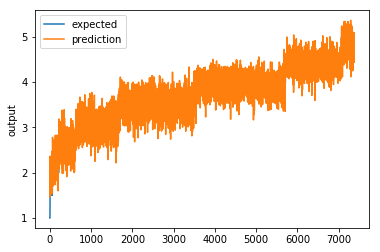

In [34]:
# Plot the chart
chart_regression(pred.flatten(),y_test_tf)

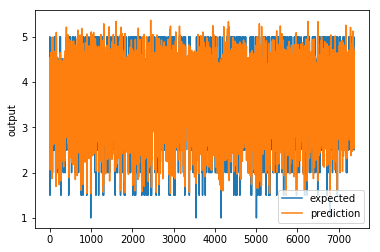

In [35]:
chart_regression(pred.flatten(),y_test_tf, sort=False)

## Linear Regression

In [36]:
x_train, x_test, y_train, y_test = train_test_split(input_data, df_ready_for_sklearn['stars'],test_size=0.25, random_state=43)

In [37]:
y_train.shape

(22131,)

In [38]:
from sklearn.linear_model import LinearRegression

# instantiate the model (using the default parameters)
linreg = LinearRegression()

# fit the model with data
linreg.fit(x_train, y_train)

# predict the response for new observations
y_pred_Linear = linreg.predict(x_test)

In [39]:
# Measure RMSE error.  RMSE is common for regression.
linear_rmse = np.sqrt(metrics.mean_squared_error(y_pred_Linear,y_test))
print("Final score (RMSE): {}".format(linear_rmse))

Final score (RMSE): 0.24851591935166453


# Classification Models

## Tensorflow

In [40]:
input_data.shape

(29508, 2001)

In [41]:
df_input = pd.DataFrame(input_data)
df_input['encoded_stars'] = df_ready_for_sklearn['encoded_stars'].values
#df_input.isnull().values.any()
x, y = to_xy(df_input, 'encoded_stars')

In [42]:
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(x, y, test_size=0.25, random_state=43)

In [43]:
x_train_tf.shape

(22131, 2001)

In [44]:
y_train_tf.shape

(22131, 9)

In [45]:
y_test_tf.shape

(7377, 9)

In [46]:
checkpointer = ModelCheckpoint(filepath=".\classification.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)
    
    #Build network
    model = Sequential()

    model.add(Dense(128, input_dim=x_train_tf.shape[1], activation='relu')) # Hidden 1     #  why input_dim=x.shape[1]?  
    model.add(Dropout(0.2)) #dropout layer
    model.add(Dense(64, activation='relu')) # Hidden 2
    model.add(Dropout(0.2)) #dropout layer
    model.add(Dense(32, activation='relu')) # Hidden 4
    model.add(Dense(y_train_tf.shape[1], activation='softmax')) # Output
    
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')

    model.fit(x_train_tf,y_train_tf, validation_data=(x_test_tf,y_test_tf), callbacks=[monitor,checkpointer],verbose=2,epochs=1000, batch_size=32, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
    
print('Training finished...Loading the best model')  
print()
model.load_weights('.\classification.hdf5') # load weights from best model

0
Train on 22131 samples, validate on 7377 samples
Epoch 1/1000
 - 4s - loss: 1.2097 - acc: 0.4899 - val_loss: 0.7948 - val_acc: 0.6580
Epoch 2/1000
 - 3s - loss: 0.7870 - acc: 0.6542 - val_loss: 0.6907 - val_acc: 0.6916
Epoch 3/1000
 - 3s - loss: 0.6901 - acc: 0.7015 - val_loss: 0.6826 - val_acc: 0.6936
Epoch 4/1000
 - 3s - loss: 0.6405 - acc: 0.7210 - val_loss: 0.6677 - val_acc: 0.7006
Epoch 5/1000
 - 3s - loss: 0.5945 - acc: 0.7422 - val_loss: 0.6413 - val_acc: 0.7113
Epoch 6/1000
 - 3s - loss: 0.5465 - acc: 0.7702 - val_loss: 0.6489 - val_acc: 0.7191
Epoch 7/1000
 - 3s - loss: 0.5135 - acc: 0.7885 - val_loss: 0.6834 - val_acc: 0.7053
Epoch 8/1000
 - 3s - loss: 0.4774 - acc: 0.8031 - val_loss: 0.6783 - val_acc: 0.7208
Epoch 9/1000
 - 3s - loss: 0.4303 - acc: 0.8252 - val_loss: 0.6994 - val_acc: 0.7161
Epoch 10/1000
 - 3s - loss: 0.4010 - acc: 0.8372 - val_loss: 0.7020 - val_acc: 0.7129
Epoch 11/1000
 - 3s - loss: 0.3626 - acc: 0.8562 - val_loss: 0.7674 - val_acc: 0.7087
Epoch 12/100

In [47]:
# Measure accuracy
pred = model.predict(x_test_tf)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test_tf,axis=1)

tf_accuracy = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(tf_accuracy))
y_test_tf

Final accuracy: 0.7291581943879626


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [48]:
tf_precision = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(tf_precision))

Precision score: 0.730939506307904


C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
tf_recall = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(tf_recall))

Recall score: 0.7291581943879626


In [50]:
tf_f1 = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(tf_f1))

F1 score: 0.7280333941486082


C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Support Vector Machine

In [51]:
#split into train/test data
#using encoded stars because classification problem
x_train, x_test, y_train, y_test = train_test_split(input_data, df_ready_for_sklearn['encoded_stars'], test_size=0.25, random_state=43)

In [52]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(22131, 2001)
(7377, 2001)
(22131,)
(7377,)


In [53]:
from sklearn.svm import LinearSVC

clf = LinearSVC(dual=False)
clf.fit(x_train, y_train)

y_pred_SVM = clf.predict(x_test)

In [54]:
# Measure accuracy
y_true = y_test
svm_accuracy = metrics.accuracy_score(y_true, y_pred_SVM)
print("Accuracy score: {}".format(svm_accuracy))

Accuracy score: 0.5235190456825267


In [55]:
svm_precision = metrics.precision_score(y_true, y_pred_SVM, average= "weighted")
print("Precision score: {}".format(svm_precision))

Precision score: 0.5172235134442837


In [56]:
svm_recall = metrics.recall_score(y_true, y_pred_SVM, average= "weighted")
print("Recall score: {}".format(svm_recall))

Recall score: 0.5235190456825267


In [57]:
svm_f1 = metrics.f1_score(y_true, y_pred_SVM, average= "weighted")
print("F1 score: {}".format(svm_f1))

F1 score: 0.5168234374576391


### Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train, y_train)

# predict the response for new observations
y_pred_Logistic = logreg.predict(x_test)

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [59]:
# Measure accuracy
y_true = y_test
logistic_accuracy = metrics.accuracy_score(y_true, y_pred_Logistic)
print("Accuracy score: {}".format(logistic_accuracy))

Accuracy score: 0.5025077944964077


In [60]:
logistic_precision = metrics.precision_score(y_true, y_pred_Logistic, average= "weighted")
print("Precision score: {}".format(logistic_precision))

Precision score: 0.49048471664360105


C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [61]:
logistic_recall = metrics.recall_score(y_true, y_pred_Logistic, average= "weighted")
print("Recall score: {}".format(logistic_recall))

Recall score: 0.5025077944964077


In [62]:
logistic_f1 = metrics.f1_score(y_true, y_pred_Logistic, average= "weighted")
print("F1 score: {}".format(logistic_f1))

F1 score: 0.4846562063672292


C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Nearest Neighbor

In [63]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model (using the value K=10)
knn = KNeighborsClassifier(n_neighbors=10)

# fit the model with data
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [64]:
# predict the response for new observations
y_neighbor = knn.predict(x_test)

In [65]:
# Measure accuracy
y_true = y_test
knn_accuracy = metrics.accuracy_score(y_true, y_neighbor)
print("Accuracy score: {}".format(knn_accuracy))

Accuracy score: 0.361800189779043


In [66]:
knn_precision = metrics.precision_score(y_true, y_neighbor, average= "weighted")
print("Precision score: {}".format(knn_precision))

Precision score: 0.3706823584286438


In [67]:
knn_recall = metrics.recall_score(y_true, y_neighbor, average= "weighted")
print("Recall score: {}".format(knn_recall))

Recall score: 0.361800189779043


In [68]:
knn_f1 = metrics.f1_score(y_true, y_neighbor, average= "weighted")
print("F1 score: {}".format(knn_f1))

F1 score: 0.34913205204298503


### Multinomial Naive Bayes

In [69]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

temp = scaler.fit_transform(df_ready_for_sklearn['review_count'].values.reshape(1, -1))

input_data_MNB = np.column_stack((reviews_tfidf, tips_tfidf))
input_data_MNB = np.column_stack((input_data_MNB, temp.reshape(-1,1)))

input_data_MNB

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


array([[0.00616463, 0.00225745, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00448781, 0.00212778, 0.00326145, ..., 0.01112818, 0.019481  ,
        0.        ],
       [0.01327496, 0.00291673, 0.00572813, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00381868, 0.00419514, 0.01235819, ..., 0.        , 0.        ,
        0.        ],
       [0.00684015, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01092898, 0.0030016 , 0.0044211 , ..., 0.        , 0.        ,
        0.        ]])

In [70]:
x_train, x_test, y_train, y_test = train_test_split(input_data_MNB, df_ready_for_sklearn['encoded_stars'], test_size=0.25, random_state=43)

In [71]:
from sklearn.naive_bayes import MultinomialNB

# instantiate the model (using the default parameters)
mnb = MultinomialNB()

# fit the model with data
mnb.fit(x_train, y_train)

# predict the response for new observations
y_mnb = mnb.predict(x_test)

In [72]:
# Measure accuracy
y_true = y_test
mnb_accuracy = metrics.accuracy_score(y_true, y_neighbor)
print("Accuracy score: {}".format(mnb_accuracy))

Accuracy score: 0.361800189779043


In [73]:
mnb_precision = metrics.precision_score(y_true, y_neighbor, average= "weighted")
print("Precision score: {}".format(mnb_precision))

Precision score: 0.3706823584286438


In [74]:
mnb_recall = metrics.recall_score(y_true, y_neighbor, average= "weighted")
print("Recall score: {}".format(mnb_recall))

Recall score: 0.361800189779043


In [75]:
mnb_f1 = metrics.f1_score(y_true, y_neighbor, average= "weighted")
print("F1 score: {}".format(mnb_f1))

F1 score: 0.34913205204298503


# Models Comparision

## Regression

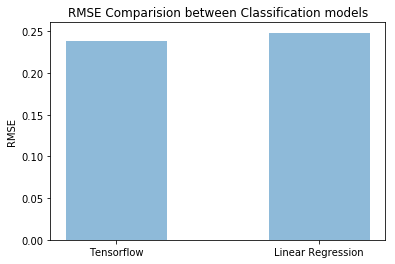

In [76]:
labels = ('Tensorflow', 'Linear Regression')
y_pos = np.arange(len(labels))
metrics = [tf_rmse, linear_rmse]

plt.bar(y_pos, metrics, align='center', alpha=0.5, width=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('RMSE')
plt.title('RMSE Comparision between Classification models')

plt.show()

## Classification

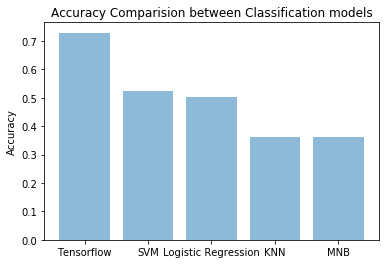

In [77]:
labels = ('Tensorflow', 'SVM', 'Logistic Regression', 'KNN', 'MNB')
y_pos = np.arange(len(labels))
metrics = [tf_accuracy, svm_accuracy, logistic_accuracy, knn_accuracy, mnb_accuracy]

plt.bar(y_pos, metrics, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparision between Classification models')

plt.show()

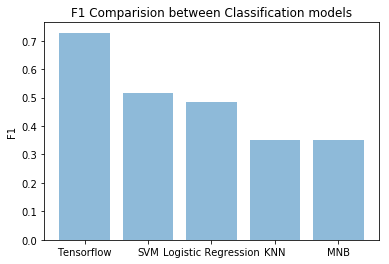

In [78]:
labels = ('Tensorflow', 'SVM', 'Logistic Regression', 'KNN', 'MNB')
y_pos = np.arange(len(labels))
metrics = [tf_f1, svm_f1, logistic_f1, knn_f1, mnb_f1]

plt.bar(y_pos, metrics, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('F1')
plt.title('F1 Comparision between Classification models')

plt.show()